In [1]:
cd("../../../temp")

In [2]:
]activate temp

  Activating project at `c:\Users\Work\Documents\Personal\Work\classes\PUCP 2024-II\repo\temp\temp`


In [3]:
using MLJ, MLJModels, RDatasets, DataFrames## Random Forests

### Fitting Forests
Here we fit a regression tree to the  `Boston`  data set.

### The Boston Data

A data set containing housing values in 506 suburbs of Boston.
     
- `crim`: per capita crime rate by town.

- `zn`: proportion of residential land zoned for lots over 25,000
sq.ft.

- `indus`: proportion of non-retail business acres per town.

- `chas`: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

- `nox`: nitrogen oxides concentration (parts per 10 million).

- `rm`: average number of rooms per dwelling.

- `age`: proportion of owner-occupied units built prior to 1940.

- `dis`: weighted mean of distances to five Boston employment centres.

- `rad`: index of accessibility to radial highways.

- `tax`: full-value property-tax rate per $10,000.

- `ptratio`: pupil-teacher ratio by town.

- `lstat`: lower status of the population (percent).

- `medv`: median value of owner-occupied homes in $1000s.

This dataset was obtained from, and is slightly modified from, the
Boston dataset that is part of the `R` library `MASS`.  References are
available in the MASS library.

The steps for regression trees are similar to those for classification trees.

In [4]:
Boston = select(dataset("MASS", "Boston"), Not(:Black));
schema(Boston)

┌─────────┬────────────┬─────────┐
│ names   │ scitypes   │ types   │
├─────────┼────────────┼─────────┤
│ Crim    │ Continuous │ Float64 │
│ Zn      │ Continuous │ Float64 │
│ Indus   │ Continuous │ Float64 │
│ Chas    │ Count      │ Int64   │
│ NOx     │ Continuous │ Float64 │
│ Rm      │ Continuous │ Float64 │
│ Age     │ Continuous │ Float64 │
│ Dis     │ Continuous │ Float64 │
│ Rad     │ Count      │ Int64   │
│ Tax     │ Count      │ Int64   │
│ PTRatio │ Continuous │ Float64 │
│ LStat   │ Continuous │ Float64 │
│ MedV    │ Continuous │ Float64 │
└─────────┴────────────┴─────────┘


In [5]:
coerce!(Boston, Count => Continuous);
y, X = unpack(Boston, ==(:MedV), !=(:MedV));
train, test = partition(eachindex(y), 0.7, shuffle = true, rng = 123);

Here we apply bagging and random forests to the `Boston` data, using
the `RandomForestRegressor()` from the `DecisionTree` package. Recall
that bagging is simply a special case of a random forest with
$m=p$. Therefore, the `RandomForestRegressor()`  function can be used to
perform both bagging and random forests. We start with bagging.

In [6]:
RandomForestRegressor = @load RandomForestRegressor pkg=DecisionTree verbosity = 0
forest_model = RandomForestRegressor(n_trees = 100, n_subfeatures = 0)
forest_machine = machine(forest_model, X[train, :], y[train])
fit!(forest_machine)

[ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).


trained Machine; caches model-specific representations of data
  model: RandomForestRegressor(max_depth = -1, …)
  args: 
    1:	Source @375 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @280 ⏎ AbstractVector{Continuous}


The argument `n_subfeatures` is 0, which in this case mean that all 12 predictors should
be considered for each split of the tree --- in other words, that
bagging should be done.  How well does this bagged model perform on
the test set?

9.740319914473684


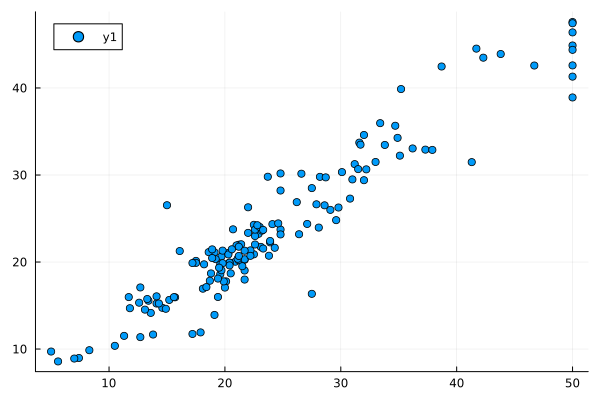

In [7]:
using Plots
using Statistics
predictions = MLJ.predict_mode(forest_machine, X[test, :])
println(mean((y[test] - predictions) .^ 2))
scatter(y[test], predictions)

The test set MSE associated with the bagged regression tree is
9.74. 

Growing a random forest proceeds in exactly the same way, except that
we use a smaller value of the `n_subfeatures` argument. By default,
`RandomForestRegressor()`  uses $p$ variables when building a random
forest of regression trees (i.e. it defaults to bagging), and `RandomForestClassifier()` uses
$\sqrt{p}$ variables when building a
random forest of classification trees. Here we use `n_subfeatures=6`.

In [ ]:
forest_model = RandomForestRegressor(n_trees = 100, n_subfeatures = 6)
forest_machine = machine(forest_model, X[train, :], y[train])
fit!(forest_machine)

predictions = MLJ.predict_mode(forest_machine, X[test, :])
println(mean((y[test] - predictions) .^ 2))

9.540670052631585


[ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).


The test set MSE is 9.5;
this indicates that random forests did somewhat better than bagging
in this case. Extracting the `feature_importances_` values from the fitted model, we can view the
importance of each variable.

In [9]:
feature_importances(forest_machine)

12-element Vector{Pair{Symbol, Float64}}:
   :LStat => 0.28291307945162475
      :Rm => 0.22701550703002313
 :PTRatio => 0.08334879231473803
     :Dis => 0.08054966863915385
   :Indus => 0.0747591243465116
    :Crim => 0.07381116124347015
     :NOx => 0.06754461530923966
     :Age => 0.03653282133177245
     :Tax => 0.03590646098805078
     :Rad => 0.014829323142631674
      :Zn => 0.012869037463717198
    :Chas => 0.009920408739066609

 This
is a relative measure of the total decrease in node impurity that results from
splits over that variable, averaged over all trees

The results indicate that across all of the trees considered in the
random forest, the wealth level of the community (`lstat`) and the
house size (`rm`) are by far the two most important variables.

  

## Causal Forest

In [10]:
using CSV
url = "https://raw.githubusercontent.com/d2cml-ai/CausalAI-Course/refs/heads/main/Labs/PD/PD10/online_discounts.csv"
df = select(CSV.read(download(url), DataFrame), Not(:Column1));

We have data on 100.000 store visitors, for whom we observe the `time` of the day the acessed the website, the `device` they use, their `browser`, and their geographical `region`. We also see whether they were offered the `discount`, our treatment, and what is their `spend`, the outcome of interest. The following code snippet describes how this effect (the value of $Y_i(1)-Y_i(0)$ for each user $i$) is generated (in Python).

```python
effect = 7*np.exp(-(df.time-18)**2/100) + 3*(df.browser=='safari') - 2*(df.device=='desktop') + (df.region=='3') - 2.5
```

Since the treatment was randomly assigned, we can use a simple **difference-in-means** estimator to estimate the treatment effect. We expect the treatment and control group to be similar, except for the `discount`, therefore we can causally attribute any difference in `spend` to the `discount`.

In [11]:
using GLM

model = lm(@formula(spend ~ discount), df)

# Display the summary of the model
model

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

spend ~ 1 + discount

Coefficients:
────────────────────────────────────────────────────────────────────────
               Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  5.12207   0.0454349  112.73    <1e-99    5.03302    5.21112
discount     1.75069   0.0642194   27.26    <1e-99    1.62482    1.87656
────────────────────────────────────────────────────────────────────────

The discount seems to be effective: on average the spend in the treatment group increases by 1.95$. But are all customers equally affected?

To answer this question, we would like to estimate **heterogeneous treatment effects**, possibly at the individual level. 
There are many different options to compute heterogeneous treatment effects. The simplest one is to interact the outcome of interest with a dimension of heterogeneity. The problem with this approach is which variable to pick. Sometimes we have prior information that might guide out actions; for example, we might know that `mobile` users on average spend more than `desktop` users. Other times, we might be interested in one dimension for business reasons; for example we might want to invest more in a certain `region`. However, when we do not extra information we would like this process to be data-driven.

In the previous Lab we have explored one data-driven approach to estimate heterogeneous treatment effects: **causal trees**. We will now expand them to causal forests.
Causal Forests are the equivalent of random forests, but for the estimation of heterogeneous treatment effects, exaxtly as for causal trees and regression trees. Exactly as for Causal Trees, we have a fundamental problem: we are interested in predicting an object that we do not observe: the individua treatment effects $\tau_i$. The solution is to create an auxiliary outcome variable $Y^*$ whose expected value for each single observation is exactly the treatment effect.

$$
Y_i^* = \frac{Y_i}{D_i \cdot p(X_i) - (1-D_i) \cdot (1-p(X_i))}
$$

Once we have an outcome variable, there are still a couple of things we need to do in order to use Random Forests to estimate heterogeneous treatment effects. First, we need to build trees that have an equal number of treated and control units in each leaf. Second, we need to use different samples to build the tree and evaluate it, i.e. compute the average outcome per leaf. This procedure is often referred to as **honest trees** and it's extremely helpful for inference, since we can treat the sample of each leaf as independent from the tree structure. 

Before we go into the estimation, let's first generate dummy variables for our categorical variables, `device`, `browser` and `region`.

In [12]:
y, X = unpack(df, ==(:spend), !=(:spend))
coerce!(X, Textual => Multiclass)
coerce!(X, Count => Multiclass);

In [13]:
D, X = unpack(X, ==(:discount), !=(:discount));

In [14]:
onehotencoder = @load OneHotEncoder pkg=MLJModels verbosity=0

ohe = onehotencoder(features = [:device, :browser, :region])
ohe_machine = machine(ohe, X)
fit!(ohe_machine);
X = MLJ.transform(ohe_machine, X);

[ Info: Training machine(OneHotEncoder(features = [:device, :browser, :region], …), …).
[ Info: Spawning 2 sub-features to one-hot encode feature :device.
[ Info: Spawning 7 sub-features to one-hot encode feature :browser.
[ Info: Spawning 10 sub-features to one-hot encode feature :region.


In Julia, we do not have the option of using a Causal Forest implementation (we would have to build it ourselves). However, we can use the next best option, which is just a regular random forest after generating the auxiliary variable $Y^*$.

In [15]:
LogisticClassifier = @load LogisticClassifier pkg=MLJScikitLearnInterface verbosity=0

log_model = LogisticClassifier()

log_model_machine = machine(log_model, X, D)

fit!(log_model_machine)

[ Info: Training machine(LogisticClassifier(penalty = l2, …), …).
c:\Users\Work\Documents\Personal\Work\classes\PUCP 2024-II\repo\temp\temp\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


trained Machine; caches model-specific representations of data
  model: LogisticClassifier(penalty = l2, …)
  args: 
    1:	Source @208 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @945 ⏎ AbstractVector{Multiclass{2}}


In [16]:
pscore = pdf.(MLJ.predict(log_model_machine, X),1)
y_star = df.spend ./ (df.discount .* pscore .- (1 .- df.discount) .* (1 .- pscore));

Now that we have built $Y^*$, we can continue with the training of the random forest.

In [17]:
X = select!(X, Not(:device__desktop, :browser__brave, :region__0));

In [18]:
forest_model = RandomForestRegressor(n_trees = 100)
forest_machine = machine(forest_model, X, y_star)
fit!(forest_machine);

[ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).


Another limitation in Julia is that when we fit Random Forests, it generates an `Ensemble` of decision trees. By definition this is correct; however, we do not have access to the singular trees, which means we cannot visualize a more interpretable individual tree. Stil, we are able to see the feature importances.

In [19]:
feature_importances(forest_machine)

17-element Vector{Pair{Symbol, Float64}}:
              :time => 0.973390576883984
    :device__mobile => 0.0029186275933171927
 :browser__explorer => 0.0018786912563834607
   :browser__chrome => 0.00186715791222209
  :browser__firefox => 0.0017547133752623708
     :browser__edge => 0.0017018409671527446
   :browser__safari => 0.0016377855045816459
         :region__2 => 0.0016152373929061846
         :region__9 => 0.0016086841091994771
    :browser__other => 0.0015544040048634162
         :region__8 => 0.0015473702633789378
         :region__1 => 0.0015352600061897623
         :region__5 => 0.0015069545224326777
         :region__7 => 0.0014563500414380654
         :region__6 => 0.0014339025347056477
         :region__4 => 0.001388463390637081
         :region__3 => 0.0012039802413456833

In [20]:
importances = DataFrame(feature_importances(forest_machine))
importances = DataFrame(variables = names(importances), importance = collect(values(importances[1, :])))

Row,variables,importance
,String,Float64
1,time,0.973391
2,device__mobile,0.00291863
3,browser__explorer,0.00187869
4,browser__chrome,0.00186716
5,browser__firefox,0.00175471
6,browser__edge,0.00170184
7,browser__safari,0.00163779
8,region__2,0.00161524
9,region__9,0.00160868


Clearly `time` is the most important dimension of heterogeneity, while all other variables are quite weak for prediction of heterogeneous causal effects.

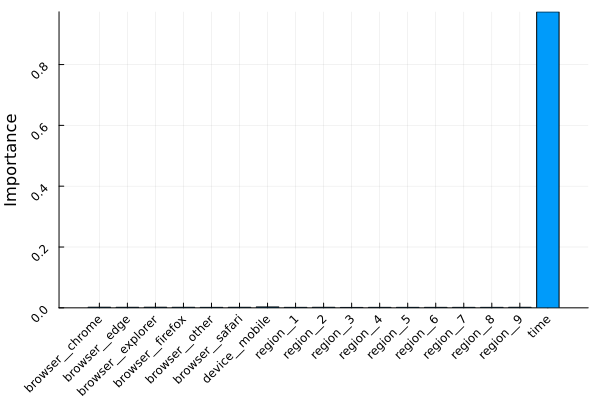

In [21]:
using CategoricalArrays
using StatsPlots

importances.variables = categorical(importances.variables, ordered=true)
sort!(importances, :importance, rev=false)

@df importances bar(:variables, :importance, legend=false)
plot!(xlabel="Variable", ylabel="Importance", xticks=(1:length(importances.variables), levels(importances.variables)), rotation=45)

Clearly `time` is the first dimension of heterogeneity, followed by `device` (mobile in particular) and `browser` (safari in particular). Other dimensions do not matter much.

We can now do a more relevant test: how well the algorithm performs with a continuous variable such as `time`? First, let’s again isolate the predicted treatment effects on `time` and ignore the other covariates.

In [22]:
df[:, "effect"] = 7 * exp.(-(df.time .- 18) .^2 ./100) + 3*(df.browser.=="safari") - 2*(df.device.=="desktop") + (df.region.=="3") .- 2.5;
df[df[:, "effect"] .< 0, "effect"] .= 0;

In [23]:
df.time_bins = round.(df.time .* 2) ./ 2
effect_bins = combine(groupby(df, :time_bins), :effect => mean => :mean_effect)

Row,time_bins,mean_effect
,Float64,Float64
1,11.0,1.31572
2,0.5,0.0725036
3,3.5,0.0991972
4,13.5,2.65623
5,22.0,2.90105
6,15.0,3.29035
7,17.5,3.93614
8,15.5,3.51059
9,14.0,2.86457


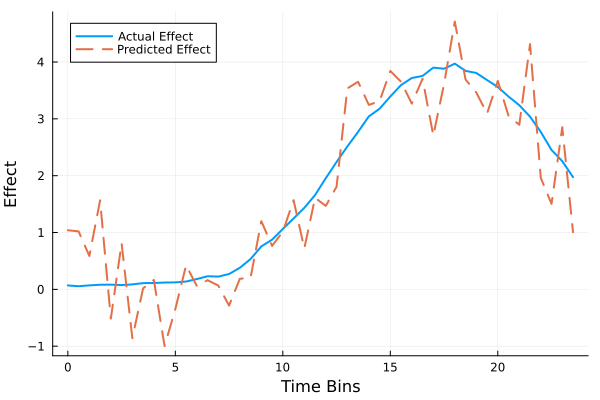

In [24]:
predicted = MLJ.predict(forest_machine, X);
df.predicted_effect = predicted
predicted_effect_bins = combine(groupby(df, :time_bins), :predicted_effect => mean => :mean_predicted_effect);
df.time_bins = floor.(df.time .* 2) ./ 2

effect_bins = combine(groupby(df, :time_bins), :effect => mean => :mean_effect)
sort!(effect_bins, :time_bins)

df.predicted_effect =  predicted

predicted_effect_bins = combine(groupby(df, :time_bins), :predicted_effect => mean => :mean_predicted_effect)
sort!(predicted_effect_bins, :time_bins)

plot(effect_bins.time_bins, effect_bins.mean_effect, label="Actual Effect", xlabel="Time Bins", ylabel="Effect", lw=2)
plot!(predicted_effect_bins.time_bins, predicted_effect_bins.mean_predicted_effect, label="Predicted Effect", lw=2, linestyle=:dash)